<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Data-Description" data-toc-modified-id="Data-Description-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data Description</a></span><ul class="toc-item"><li><span><a href="#Model-Introduction" data-toc-modified-id="Model-Introduction-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Model Introduction</a></span></li></ul></li><li><span><a href="#Imports" data-toc-modified-id="Imports-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#Important-Scripts" data-toc-modified-id="Important-Scripts-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Important Scripts</a></span></li><li><span><a href="#Parameters" data-toc-modified-id="Parameters-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Parameters</a></span></li><li><span><a href="#Load-the-data" data-toc-modified-id="Load-the-data-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Load the data</a></span></li><li><span><a href="#Data-Processing" data-toc-modified-id="Data-Processing-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Data Processing</a></span></li><li><span><a href="#Train-Test-Split" data-toc-modified-id="Train-Test-Split-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Train Test Split</a></span></li><li><span><a href="#Scaling" data-toc-modified-id="Scaling-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Scaling</a></span></li><li><span><a href="#Fitting" data-toc-modified-id="Fitting-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Fitting</a></span></li></ul></div>

<div class="alert alert-block alert-success">
<b>Kernel Author:</b>  <br>
<a href="https://bhishanpdl.github.io/" , target="_blank">Bhishan Poudel,  Data Scientist, Ph.D Astrophysics</a> .
</div>

# Data Description

This dataset contains house sale prices for King County,
which includes Seattle.
It includes homes sold between May 2014 and May 2015.

- Dependent features: 1 (price)
- Features : 19 home features
- Id:  1 house ID

Task: Estimate the price based on given features.

![](images/data_description.png)


## Model Introduction
Here we will use deep learning method using keras and tensorflow for the regression problem of house price prediction.

# Imports

In [1]:
import time
time_start_notebook = time.time()

In [2]:
%%capture
import os
import sys
ENV_COLAB = 'google.colab' in sys.modules

if ENV_COLAB:
    ## install modules
    !pip install scikit-plot
    !pip install lrcurve
    !pip install watermark
    !pip install -U scikit-learn

    ## print
    print('Environment: Google Colaboratory.')

In [3]:
import numpy as np
import pandas as pd

# visualization
import seaborn as sns
sns.set(color_codes=True)
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# random state
SEED = 0
RNG = np.random.RandomState(SEED)

# sklearn
import sklearn
from sklearn import model_selection
from sklearn import preprocessing

# deep learning
import tensorflow
import tensorflow as tf
import keras
import keras.backend as K
from keras.models import Sequential
from keras.layers import Activation
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from keras.wrappers.scikit_learn import KerasRegressor

# model evaluation
import scikitplot
from scikitplot import metrics as skmetrics
import lrcurve
from lrcurve import KerasLearningCurve

# versions
import watermark
%load_ext watermark
%watermark -a "Bhishan Poudel" -d -v -m
print()
%watermark -iv

Bhishan Poudel 2020-11-08 

CPython 3.6.9
IPython 5.5.0

compiler   : GCC 8.4.0
system     : Linux
release    : 4.19.112+
machine    : x86_64
processor  : x86_64
CPU cores  : 2
interpreter: 64bit

pandas     1.1.4
matplotlib 3.2.2
watermark  2.0.2
sklearn    0.23.2
seaborn    0.11.0
keras      2.4.3
scikitplot 0.3.7
tensorflow 2.3.0
numpy      1.18.5



# Important Scripts

In [4]:
def set_random_seed(seed):
    import os
    import random
    import numpy as np
    import tensorflow as tf
    
    os.environ['PYTHONHASHSEED']=str(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

In [5]:
def show_methods(obj, ncols=7,start=None, inside=None):
    """ Show all the attributes of a given method.
    Example:
    ========
    show_method_attributes(list)
     """

    print(f'Object Type: {type(obj)}\n')
    lst = [elem for elem in dir(obj) if elem[0]!='_' ]
    lst = [elem for elem in lst 
           if elem not in 'os np pd sys time psycopg2'.split() ]

    if isinstance(start,str):
        lst = [elem for elem in lst if elem.startswith(start)]
        
    if isinstance(start,tuple) or isinstance(start,list):
        lst = [elem for elem in lst for start_elem in start
               if elem.startswith(start_elem)]
        
    if isinstance(inside,str):
        lst = [elem for elem in lst if inside in elem]
        
    if isinstance(inside,tuple) or isinstance(inside,list):
        lst = [elem for elem in lst for inside_elem in inside
               if inside_elem in elem]

    return pd.DataFrame(np.array_split(lst,ncols)).T.fillna('')

In [6]:
def adjustedR2(rsquared,nrows,kcols):
    """
    Adjusted r-squared depends on number of rows and columns of Test data.

    It reduces the value of original r-squared value.
    """
    return rsquared- (kcols-1)/(nrows-kcols) * (1-rsquared)

In [7]:
def get_model(params,metrics,n_feats):

    # num of layers
    n_layers = len([i for i in list(params.keys()) if i.endswith('_units')])

    # layers
    model = keras.Sequential(name='Sequential')

    # layer 1
    model.add(keras.layers.Dense(
        params['L1_units'],
        activation=params['L1_act'],
        kernel_initializer=params['L1_kernel_init'],
        input_shape=(n_feats,),
        name='Layer_1'
        ))
    model.add(keras.layers.Dropout(params['L1_dropout'],
                                seed=SEED,
                                name='Dropout_1'))

    # middle layers
    for i in range(2,n_layers+1): # 2,3, etc
        model.add(keras.layers.Dense(
            params[f'L{i}_units'],
            activation=params[f'L{i}_act'],
            kernel_initializer=params[f'L{i}_kernel_init'],
            kernel_regularizer=params[f'L{i}_kernel_reg'],
            bias_regularizer=params[f'L{i}_bias_reg'],
            name=f'Layer_{i}'),)
        model.add(keras.layers.Dropout(
            params[f'L{i}_dropout'],
            seed=SEED,
            name=f"Dropout_{i}"))

    # last layer is dense 1 with activation sigmoid
    model.add(keras.layers.Dense(
        1,
        activation=None, # activation = None or linear does nothing
        name=f'Layer_{n_layers+1}'
        ))

    #=================================================== compile
    model.compile(
        optimizer=params['optimizer'],
        loss='mse',
        metrics=metrics
        )

    return model

In [8]:
def print_reg_metrics(yt,yp,ncols):
    rmse = np.sqrt(sklearn.metrics.mean_squared_error(yt,yp))
    r2 = sklearn.metrics.r2_score(yt, yp)
    ar2 = adjustedR2(r2, len(yt), ncols)

    out = f"""
    RMSE     : {rmse:,.2f}
    R-squared: {r2:,.6f}
    Adj R2   : {ar2:,.6f}
    """
    print(out)

In [33]:
def plot_keras_history(h, metric,figsize=(12,8),ofile=None):
    # history
    if not isinstance(h,dict):
        h = h.history

    # prepare plot
    fig, axes = plt.subplots(nrows=4, ncols=4, sharex=True,figsize=figsize)

    # metric
    plt.subplot(211)
    plt.plot(h[metric])
    plt.plot(h['val_'+metric])
    plt.title('Training vs Validation '+ metric.upper())
    plt.ylabel(metric)
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # loss
    plt.subplot(212)
    plt.plot(h['loss'])
    plt.plot(h['val_loss'])
    plt.title('Training vs Validation Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # save
    plt.tight_layout()
    plt.savefig(ofile,dpi=300)

    # show plot
    plt.draw()
    plt.show()


# Parameters

In [9]:
if ENV_COLAB:
    path_raw = 'https://raw.githubusercontent.com/bhishanpdl/Datasets/master/'
    proj = 'Projects/King_County_Seattle_House_Price_Kaggle/'
    data_path_parent = path_raw + proj
    data_path_train = data_path_parent + 'raw/train.csv'
    data_path_test = data_path_parent + 'raw/test.csv'

else:
    data_path_parent = '../data/'
    data_path_train = data_path_parent + 'raw/train.csv'
    data_path_test = data_path_parent + 'raw/test.csv'

target = 'price'
train_size = 0.8

print(data_path_train)

https://raw.githubusercontent.com/bhishanpdl/Datasets/master/Projects/King_County_Seattle_House_Price_Kaggle/raw/train.csv


# Load the data

In [10]:
df_train_raw = pd.read_csv(data_path_train)
df_test_raw = pd.read_csv(data_path_test)
print(df_train_raw.shape)
print(df_train_raw.columns)

display(df_train_raw.head(2).append(df_train_raw.tail(2)))

(17290, 21)
Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,2561340020,20140804T000000,325000.0,3,1.75,1780,11096,1.0,0,0,3,7,1210,570,1979,0,98074,47.6170,-122.051,1780,10640
1,8598200070,20141208T000000,278000.0,2,2.50,1420,2229,2.0,0,0,3,7,1420,0,2004,0,98059,47.4871,-122.165,1500,2230
17288,7174800760,20140725T000000,667000.0,5,2.00,1900,5470,1.0,0,0,3,7,1180,720,1930,1965,98105,47.6666,-122.303,1300,3250
17289,9521100280,20140612T000000,480000.0,3,2.50,1250,1103,3.0,0,2,3,8,1250,0,2005,0,98103,47.6619,-122.352,1250,1188


# Data Processing

In [11]:
def clean_data(df):
    df = df.copy()

    # Date time features
    df['date'] = pd.to_datetime(df['date'])
    df['yr_sales'] = df['date'].dt.year
    df['age'] = df['yr_sales'] - df['yr_built']
    df['yr_renovated2'] = np.where(df['yr_renovated'].eq(0), df['yr_built'],
                                   df['yr_renovated'])
    df['age_after_renovation'] = df['yr_sales'] - df['yr_renovated2']

    # Boolean data types
    df['basement_bool'] = df['sqft_basement'].apply(lambda x: 1 if x>0 else 0)
    df['renovation_bool'] = df['yr_renovated'].apply(lambda x: 1 if x>0 else 0)

    # Log transformation of large numerical values
    cols_log = ['sqft_living', 'sqft_lot', 'sqft_above',
                'sqft_basement', 'sqft_living15', 'sqft_lot15']

    for col in cols_log:
        df['log1p_' + col] = np.log1p(df[col])

    # Drop unwanted columns
    cols_drop = ['id','date']
    df = df.drop(cols_drop,axis=1)

    return df

In [12]:
df_train = clean_data(df_train_raw)
df_test = clean_data(df_test_raw)

# Train Test Split

In [13]:
# choose features to train, we can change it later
features = list(sorted(df_train.columns.drop(target)))
# print(np.array(features))

In [14]:
features = [i for i in features if i in df_test.columns if i in df_train.columns]
# print(np.array(sorted(features)))

In [15]:
df_Xtrain  = df_train[features]
ser_ytrain = df_train[target]

df_Xtest  = df_test[features]
ser_ytest = df_test[target]

ytrain = np.array(ser_ytrain).flatten()
ytest  = np.array(ser_ytest).flatten()

# Scaling

In [16]:
scaling = 'standard'
if scaling == 'standard':
    scaler = preprocessing.StandardScaler()
    scaler.fit(df_Xtrain)
    Xtrain = scaler.transform(df_Xtrain)
    Xtest =  scaler.transform(df_Xtest)
elif scaling == 'minmax':
    scaler = preprocessing.MinMaxScaler()
    scaler.fit(df_Xtrain)
    Xtrain = scaler.transform(df_Xtrain)
    Xtest = scaler.transform(df_Xtest)

df_Xtrain.head(2)

,age,age_after_renovation,basement_bool,bathrooms,bedrooms,condition,floors,grade,lat,log1p_sqft_above,log1p_sqft_basement,log1p_sqft_living,log1p_sqft_living15,log1p_sqft_lot,log1p_sqft_lot15,long,renovation_bool,sqft_above,sqft_basement,sqft_living,sqft_living15,sqft_lot,sqft_lot15,view,waterfront,yr_built,yr_renovated,yr_renovated2,yr_sales,zipcode
0,35,35,1,1.75,3,3,1.0,7,47.6170,7.099202,6.347389,7.484930,7.484930,9.314430,9.272470,-122.051,0,1210,570,1780,1780,11096,10640,0,0,1979,0,1979,2014,98074
1,10,10,0,2.50,2,3,2.0,7,47.4871,7.259116,0.000000,7.259116,7.313887,7.709757,7.710205,-122.165,0,1420,0,1420,1500,2229,2230,0,0,2004,0,2004,2014,98059


# Fitting

In [17]:
n_feats = len(features)
#===============================================================================
PARAMS_MODEL = {
    # first layer
    'L1_units'      : 80,
    'L1_act'        : 'tanh',
    'L1_kernel_init': 'normal',
    'L1_kernel_reg' : None,
    'L1_bias_reg'   : None,
    'L1_dropout'    : 0.2,

    # layer 2
    'L2_units'      : 120,
    'L2_act'        : 'relu',
    'L2_kernel_init': 'normal',
    'L2_kernel_reg' : keras.regularizers.l1(0.01),
    'L2_bias_reg'   : keras.regularizers.l1(0.01),
    'L2_dropout'    : 0.1,

    # layer 3
    'L3_units'      : 20,
    'L3_act'        : 'relu',
    'L3_kernel_init': 'normal',
    'L3_kernel_reg' : keras.regularizers.l1_l2(0.01),
    'L3_bias_reg'   : keras.regularizers.l1_l2(0.01),
    'L3_dropout'    : 0.1,

    # layer 4
    'L4_units'      : 10,
    'L4_act'        : 'relu',
    'L4_kernel_init': 'normal',
    'L4_kernel_reg' : None,
    'L4_bias_reg'   : None,
    'L4_dropout'    : 0.0,

    # NOTE: last layer is defined in model definition.

    # optimizer
    'optimizer': keras.optimizers.Nadam(learning_rate=0.001,
                                       beta_1=0.9,
                                       beta_2=0.999,
                                       epsilon=1e-07,
                                       name="Nadam"),
}

#===============================================================================
METRICS = ['mae' ] # for regression val_mae gave better than val_mse

#===============================================================================
PARAMS_FIT = {'epochs': 500,
          'batch_size': 128,
          'patience': 20,
          'shuffle': True,
          'validation_split': 0.2
          }

#===============================================================================
# callbacks
cb_early = tf.keras.callbacks.EarlyStopping(
    monitor='val_mae', # val_auc for classification 
    patience=PARAMS_FIT['patience'],
    verbose=0
)

# cb_checkpt = keras.callbacks.ModelCheckpoint("model_at_epoch_{epoch}.h5")
cb_lr = lrcurve.KerasLearningCurve()
callbacks = [cb_lr]
#===============================================================================

model = get_model(PARAMS_MODEL,METRICS,n_feats)
print(model.summary())
history = model.fit(
    Xtrain,
    ytrain,
    batch_size=PARAMS_FIT['batch_size'],
    epochs=PARAMS_FIT['epochs'],
    verbose=0,
    callbacks=[cb_early],
    validation_split = PARAMS_FIT['validation_split'],
)

ypreds = model.predict(Xtest).flatten()
print_reg_metrics(ytest,ypreds,Xtest.shape[1])

Model: "Sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Layer_1 (Dense)              (None, 80)                2480      
_________________________________________________________________
Dropout_1 (Dropout)          (None, 80)                0         
_________________________________________________________________
Layer_2 (Dense)              (None, 120)               9720      
_________________________________________________________________
Dropout_2 (Dropout)          (None, 120)               0         
_________________________________________________________________
Layer_3 (Dense)              (None, 20)                2420      
_________________________________________________________________
Dropout_3 (Dropout)          (None, 20)                0         
_________________________________________________________________
Layer_4 (Dense)              (None, 10)                2

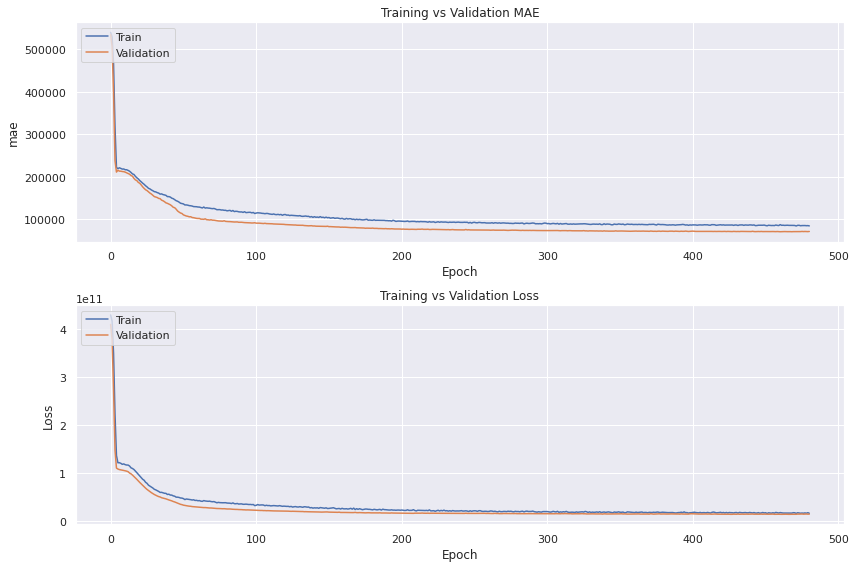

In [31]:
plot_keras_history(history,'mae')